In [1]:
from datetime import datetime as dt
import uuid 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [3]:
in_path = './../../../'
dataset = pd.read_csv(
    in_path+'splunk_data_180918_telenor.txt',  
    encoding="ISO-8859-1", 
    dtype={
        "user_id": int, 
        "visit_id": int, 
        "sequence": int, 
        "start_time":object, 
        "event_duration":float,
        "url":str, 
        "action":str, 
        "country":str,
        "user_client":str,
        "user_client_family":str,
        "user_experience":str,
        "user_os":str,
        "apdex_user_experience":str,
        "bounce_rate":float,
        "session_duration":float
    }
)

t = dataset
t.columns = t.columns.str.replace('min_bedrift_event.','')
t = t[~t.action.isnull()]

# drop NaN actions or urls
t = t.dropna(axis='rows', how='any',subset=['url', 'action'])
#t = t.reset_index()

In [6]:
 # define time variables
# define time variables
t['start_time'] = t['start_time'].apply(lambda x: dt.strptime(str(x), "%Y-%m-%d %H:%M:%S:%f"))
t['start_time'] = t['start_time'].apply(lambda x: x.replace(microsecond=0))

t['date'] = t['start_time'].dt.date
t['hour'] = t['start_time'].dt.hour
t['DOW'] = t['start_time'].dt.dayofweek

# create new session_id based on load = "new browser session"
# visit_id is not a good measure, since people remain logged in for 1 hour. This was previously 2 hours.
# in the App, people remain logged in for 11 months, so visit_ids could carry on for a long time
# Advice: I would define a session based on inactivity. Create new session after 30 minutes inactivity
t.sort_values(['visit_id', 'start_time'], inplace=True)

t['lag_ts'] = t.sort_values(['visit_id','start_time']).groupby('visit_id')['start_time'].shift(1)
#t['lag_ts'].fillna(t['start_time'],inplace=True) # for the first event in session
t['inactivity'] = (t['start_time'] - t['lag_ts']) / np.timedelta64(1, 'm')

cond_inactivity = t.inactivity > 30
cond_url_not_NaN = t.url is not np.nan
cond_lag_ts_NaN = t.lag_ts is np.nan
cond_login = ((t.url == 'https://www.telenor.no/bedrift/minbedrift/beta/#/') | (t.url == 'https://www.telenor.no/bedrift/minbedrift/beta/') | (t.url == 'https://www.telenor.no/bedrift/minbedrift/beta/mobile-app.html#/')) & ("_load_" in t.action)
cond = cond_url_not_NaN & ((cond_login & cond_lag_ts_NaN) | cond_inactivity)

t['tmp'] = cond.groupby(t.visit_id).cumsum().where(cond, 0).astype(int).replace(to_replace=0, method='ffill')

t['sequence'] = t.groupby(['tmp', 'visit_id']).cumcount() + 1
t['UUID'] = 1
t.loc[:, "UUID"] = t.groupby(['user', 'tmp', 'visit_id'])['UUID'].transform(lambda g: uuid.uuid4())

# drop all sessions with 1 event (since they are duplicates)
t['uuid_count'] = t.groupby('UUID').UUID.transform('count')
t = t[t.uuid_count > 1]

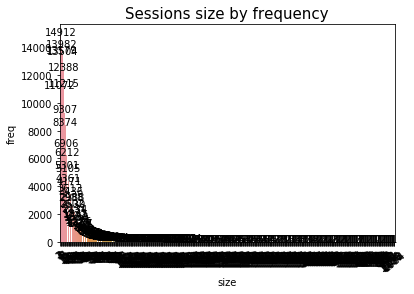

In [7]:
df = pd.DataFrame({'size':t.groupby('UUID').size()})
freq = pd.DataFrame({'freq':df.groupby('size').size()})
freq['size'] = freq.index
freq['inx'] = range(len(freq))
ax = sns.barplot(x="size", y="freq", data=freq)
ax.set_xticklabels(freq["size"], rotation=40)
for index, row in freq.iterrows():
    ax.text(row.inx, row.freq, row.freq, color='black', ha="center")
plt.title("Sessions size by frequency", fontsize=15)
plt.savefig('img/session_freq.png')

In [8]:
pd.set_option('display.max_columns', None)
tail = t.tail(1000)
#tail = tail[tail.uuid_count == 2]
tail

,visit_id,sequence,start_time,event_duration,url,action,country,user_client,user_client_family,user_experience,user_os,apdex_user_experience,bounce_rate,session_duration,site,duration,exec_time,failed,partition_date,user,date,hour,DOW,lag_ts,inactivity,tmp,UUID,uuid_count
3872148,30479451,21,2018-09-17 10:55:21,11.556,https://www.telenor.no/bedrift/minbedrift/beta...,"click on ""list""",Norway - Oslo - Oslo,Edge 17.17134,Edge,tolerating,Windows,satisfied,NaN,238.754,NaN,2071.000000,3002.000000,NaN,2018-09-17,5853,2018-09-17,10,0,2018-09-17 10:55:09,0.200000,1,3abf8987-fa38-462f-9281-889ce9594770,26
3872177,30479451,22,2018-09-17 10:55:46,25.714,https://www.telenor.no/bedrift/minbedrift/beta...,"scroll on ""Page: https://www.telenor.no/bedrif...",Norway - Oslo - Oslo,Edge 17.17134,Edge,tolerating,Windows,satisfied,NaN,238.754,NaN,784.000000,784.000000,NaN,2018-09-17,5853,2018-09-17,10,0,2018-09-17 10:55:21,0.416667,1,3abf8987-fa38-462f-9281-889ce9594770,26
3872179,30479451,23,2018-09-17 10:55:47,0.733,https://www.telenor.no/bedrift/minbedrift/beta...,"scroll on ""Page: https://www.telenor.no/bedrif...",Norway - Oslo - Oslo,Edge 17.17134,Edge,tolerating,Windows,satisfied,NaN,238.754,NaN,1068.000000,1068.000000,NaN,2018-09-17,5853,2018-09-17,10,0,2018-09-17 10:55:46,0.016667,1,3abf8987-fa38-462f-9281-889ce9594770,26
3872183,30479451,24,2018-09-17 10:55:49,1.570,https://www.telenor.no/bedrift/minbedrift/beta...,"scroll on ""Page: https://www.telenor.no/bedrif...",Norway - Oslo - Oslo,Edge 17.17134,Edge,tolerating,Windows,satisfied,NaN,238.754,NaN,817.000000,817.000000,NaN,2018-09-17,5853,2018-09-17,10,0,2018-09-17 10:55:47,0.033333,1,3abf8987-fa38-462f-9281-889ce9594770,26
3872184,30479451,25,2018-09-17 10:55:49,0.266,https://www.telenor.no/bedrift/minbedrift/beta...,"scroll on ""Page: https://www.telenor.no/bedrif...",Norway - Oslo - Oslo,Edge 17.17134,Edge,tolerating,Windows,satisfied,NaN,238.754,NaN,1224.000000,1224.000000,NaN,2018-09-17,5853,2018-09-17,10,0,2018-09-17 10:55:49,0.000000,1,3abf8987-fa38-462f-9281-889ce9594770,26
3872188,30479451,26,2018-09-17 10:55:55,6.315,https://www.telenor.no/bedrift/minbedrift/beta...,"click on ""948 95 069""",Norway - Oslo - Oslo,Edge 17.17134,Edge,tolerating,Windows,satisfied,NaN,238.754,NaN,2136.000000,8260.000000,NaN,2018-09-17,5853,2018-09-17,10,0,2018-09-17 10:55:49,0.100000,1,3abf8987-fa38-462f-9281-889ce9594770,26
3871884,30479467,1,2018-09-17 10:51:20,0.000,https://www.telenor.no/bedrift/minbedrift/beta...,_load_,Norway - Hordaland,Chrome 69.0,Chrome,frustrated,Windows,frustrated,NaN,192.567,NaN,12254.586426,12482.586426,NaN,2018-09-17,21659,2018-09-17,10,0,NaT,NaN,1,9863b9ce-7b59-49de-877c-d305f0f70814,6
3871904,30479467,2,2018-09-17 10:51:27,7.720,https://www.telenor.no/bedrift/minbedrift/beta...,"click on ""Abonnement""",Norway - Hordaland,Chrome 69.0,Chrome,frustrated,Windows,frustrated,NaN,192.567,NaN,1145.000000,1299.000000,NaN,2018-09-17,21659,2018-09-17,10,0,2018-09-17 10:51:20,0.116667,1,9863b9ce-7b59-49de-877c-d305f0f70814,6
3871909,30479467,3,2018-09-17 10:51:31,3.920,https://www.telenor.no/bedrift/minbedrift/beta...,"keypress <RETURN> on ""search-input ng-untouche...",Norway - Hordaland,Chrome 69.0,Chrome,frustrated,Windows,frustrated,NaN,192.567,NaN,984.000000,984.000000,NaN,2018-09-17,21659,2018-09-17,10,0,2018-09-17 10:51:27,0.066667,1,9863b9ce-7b59-49de-877c-d305f0f70814,6
3871915,30479467,4,2018-09-17 10:51:34,2.750,https://www.telenor.no/bedrift/minbedrift/beta...,"click on ""KÃÂ RE NETELAND AS""",Norway - Hordaland,Chrome 69.0,Chrome,frustrated,Windows,frustrated,NaN,192.567,NaN,4815.000000,5567.000000,NaN,2018-09-17,21659,2018-09-17,10,0,2018-09-17 10:51:31,0.050000,1,9863b9ce-7b59-49de-877c-d305f0f70814,6


In [19]:
small_session = dataset.loc[dataset['visit_id'] == 30480842]
small_session

,visit_id,sequence,start_time,event_duration,url,action,country,user_client,user_client_family,user_experience,user_os,apdex_user_experience,bounce_rate,session_duration,site,duration,exec_time,failed,partition_date,user
3873179,30480842,1,2018-09-17 11:13:09:690,NaN,NaN,NaN,Norway - Sor-Trondelag - Trondheim,IE 11.0,IE,satisfied,Windows,satisfied,NaN,41.429,NaN,691.00000,691.00000,NaN,2018-09-17,1380
3873180,30480842,2,2018-09-17 11:13:09:690,0.000,NaN,NaN,Norway - Sor-Trondelag - Trondheim,IE 11.0,IE,satisfied,Windows,satisfied,NaN,41.429,NaN,691.00000,691.00000,NaN,2018-09-17,1380
3873181,30480842,3,2018-09-17 11:13:09:690,0.000,NaN,NaN,Norway - Sor-Trondelag - Trondheim,IE 11.0,IE,satisfied,Windows,satisfied,NaN,41.429,NaN,691.00000,691.00000,NaN,2018-09-17,1380
3873182,30480842,4,2018-09-17 11:13:09:690,0.000,https://www.telenor.no/bedrift/minbedrift/beta/#/,_load_,Norway - Sor-Trondelag - Trondheim,IE 11.0,IE,satisfied,Windows,satisfied,NaN,41.429,NaN,5230.19873,5999.19873,NaN,2018-09-17,1380
3873215,30480842,5,2018-09-17 11:13:29:938,20.248,https://www.telenor.no/bedrift/minbedrift/beta/#/,"click on ""Nytt abonnement eller eierskifte""",Norway - Sor-Trondelag - Trondheim,IE 11.0,IE,satisfied,Windows,satisfied,NaN,41.429,NaN,311.00000,311.00000,NaN,2018-09-17,1380
3873216,30480842,6,2018-09-17 11:13:31:841,1.903,https://www.telenor.no/bedrift/minbedrift/beta/#/,"click on ""Opprett nytt abonnement fra grunnen av""",Norway - Sor-Trondelag - Trondheim,IE 11.0,IE,satisfied,Windows,satisfied,NaN,41.429,NaN,192.00000,192.00000,NaN,2018-09-17,1380
3873219,30480842,7,2018-09-17 11:13:33:590,1.750,https://www.telenor.no/bedrift/minbedrift/beta/#/,"click on ""Abonnement for tale og data""",Norway - Sor-Trondelag - Trondheim,IE 11.0,IE,satisfied,Windows,satisfied,NaN,41.429,NaN,823.00000,823.00000,NaN,2018-09-17,1380
3873221,30480842,8,2018-09-17 11:13:36:160,2.570,https://www.telenor.no/bedrift/minbedrift/beta...,"click on ""Fortsett""",Norway - Sor-Trondelag - Trondheim,IE 11.0,IE,satisfied,Windows,satisfied,NaN,41.429,NaN,2640.00000,7173.00000,NaN,2018-09-17,1380
3873254,30480842,9,2018-09-17 11:14:00:301,24.141,https://www.telenor.no/bedrift/minbedrift/beta...,"click on ""Finn person""",Norway - Sor-Trondelag - Trondheim,IE 11.0,IE,satisfied,Windows,satisfied,NaN,41.429,NaN,436.00000,436.00000,NaN,2018-09-17,1380
3873269,30480842,10,2018-09-17 11:14:09:732,9.431,https://www.telenor.no/bedrift/minbedrift/beta...,"click on ""Neste Lagre""",Norway - Sor-Trondelag - Trondheim,IE 11.0,IE,satisfied,Windows,satisfied,NaN,41.429,NaN,404.00000,404.00000,NaN,2018-09-17,1380


In [20]:
s = t.loc[t['visit_id'] == 30480842]
s

,visit_id,sequence,start_time,event_duration,url,action,country,user_client,user_client_family,user_experience,user_os,apdex_user_experience,bounce_rate,session_duration,site,duration,exec_time,failed,partition_date,user,date,hour,DOW,lag_ts,inactivity,tmp,UUID,uuid_count
3873182,30480842,1,2018-09-17 11:13:09,0.000,https://www.telenor.no/bedrift/minbedrift/beta/#/,_load_,Norway - Sor-Trondelag - Trondheim,IE 11.0,IE,satisfied,Windows,satisfied,NaN,41.429,NaN,5230.19873,5999.19873,NaN,2018-09-17,1380,2018-09-17,11,0,NaT,NaN,1,b2c05eca-d0e9-40e0-9705-9620cbeb4448,9
3873215,30480842,2,2018-09-17 11:13:29,20.248,https://www.telenor.no/bedrift/minbedrift/beta/#/,"click on ""Nytt abonnement eller eierskifte""",Norway - Sor-Trondelag - Trondheim,IE 11.0,IE,satisfied,Windows,satisfied,NaN,41.429,NaN,311.00000,311.00000,NaN,2018-09-17,1380,2018-09-17,11,0,2018-09-17 11:13:09,0.333333,1,b2c05eca-d0e9-40e0-9705-9620cbeb4448,9
3873216,30480842,3,2018-09-17 11:13:31,1.903,https://www.telenor.no/bedrift/minbedrift/beta/#/,"click on ""Opprett nytt abonnement fra grunnen av""",Norway - Sor-Trondelag - Trondheim,IE 11.0,IE,satisfied,Windows,satisfied,NaN,41.429,NaN,192.00000,192.00000,NaN,2018-09-17,1380,2018-09-17,11,0,2018-09-17 11:13:29,0.033333,1,b2c05eca-d0e9-40e0-9705-9620cbeb4448,9
3873219,30480842,4,2018-09-17 11:13:33,1.750,https://www.telenor.no/bedrift/minbedrift/beta/#/,"click on ""Abonnement for tale og data""",Norway - Sor-Trondelag - Trondheim,IE 11.0,IE,satisfied,Windows,satisfied,NaN,41.429,NaN,823.00000,823.00000,NaN,2018-09-17,1380,2018-09-17,11,0,2018-09-17 11:13:31,0.033333,1,b2c05eca-d0e9-40e0-9705-9620cbeb4448,9
3873221,30480842,5,2018-09-17 11:13:36,2.570,https://www.telenor.no/bedrift/minbedrift/beta...,"click on ""Fortsett""",Norway - Sor-Trondelag - Trondheim,IE 11.0,IE,satisfied,Windows,satisfied,NaN,41.429,NaN,2640.00000,7173.00000,NaN,2018-09-17,1380,2018-09-17,11,0,2018-09-17 11:13:33,0.050000,1,b2c05eca-d0e9-40e0-9705-9620cbeb4448,9
3873254,30480842,6,2018-09-17 11:14:00,24.141,https://www.telenor.no/bedrift/minbedrift/beta...,"click on ""Finn person""",Norway - Sor-Trondelag - Trondheim,IE 11.0,IE,satisfied,Windows,satisfied,NaN,41.429,NaN,436.00000,436.00000,NaN,2018-09-17,1380,2018-09-17,11,0,2018-09-17 11:13:36,0.400000,1,b2c05eca-d0e9-40e0-9705-9620cbeb4448,9
3873269,30480842,7,2018-09-17 11:14:09,9.431,https://www.telenor.no/bedrift/minbedrift/beta...,"click on ""Neste Lagre""",Norway - Sor-Trondelag - Trondheim,IE 11.0,IE,satisfied,Windows,satisfied,NaN,41.429,NaN,404.00000,404.00000,NaN,2018-09-17,1380,2018-09-17,11,0,2018-09-17 11:14:00,0.150000,1,b2c05eca-d0e9-40e0-9705-9620cbeb4448,9
3873270,30480842,8,2018-09-17 11:14:11,1.635,https://www.telenor.no/bedrift/minbedrift/beta...,"click on ""Neste Lagre""",Norway - Sor-Trondelag - Trondheim,IE 11.0,IE,satisfied,Windows,satisfied,NaN,41.429,NaN,413.00000,413.00000,NaN,2018-09-17,1380,2018-09-17,11,0,2018-09-17 11:14:09,0.033333,1,b2c05eca-d0e9-40e0-9705-9620cbeb4448,9
3873279,30480842,9,2018-09-17 11:14:24,13.147,https://www.telenor.no/bedrift/minbedrift/beta...,"click on ""Neste Lagre""",Norway - Sor-Trondelag - Trondheim,IE 11.0,IE,satisfied,Windows,satisfied,NaN,41.429,NaN,691.00000,691.00000,NaN,2018-09-17,1380,2018-09-17,11,0,2018-09-17 11:14:11,0.216667,1,b2c05eca-d0e9-40e0-9705-9620cbeb4448,9
